In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn nltk vaderSentiment jupyter


   -------- ------------------------------- 1/5 [uri-template]
   ------------------------ --------------- 3/5 [vaderSentiment]
   ------------------------ --------------- 3/5 [vaderSentiment]
   ------------------------ --------------- 3/5 [vaderSentiment]
   -------------------------------- ------- 4/5 [isoduration]
   ---------------------------------------- 5/5 [isoduration]

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

df = pd.read_csv("C://Users//hp//Documents//employee_sentiment_analysis//test.csv")
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [5]:
df['text'] = df['Subject'].fillna('') + ' ' + df['body'].fillna('')


In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def label_sentiment(text):
    score = analyzer.polarity_scores(str(text))['compound']
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['text'].apply(label_sentiment)
df[['Subject', 'sentiment']].head()

,Subject,sentiment
0,EnronOptions Update!,Positive
1,(No Subject),Positive
2,Phone Screen Interview - Shannon L. Burnham,Neutral
3,RE: My new work email,Neutral
4,Bet,Positive


In [7]:
score_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['score'] = df['sentiment'].map(score_map)

In [8]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')

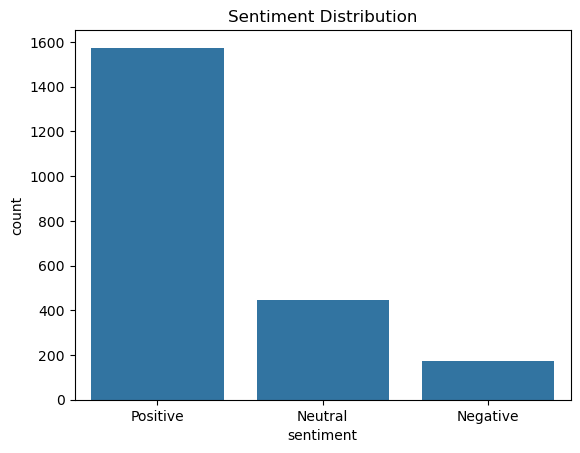

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

In [10]:
monthly_scores = (
    df.groupby(['from', 'month'])['score']
      .sum()
      .reset_index()
)

monthly_scores.head()

,from,month,score
0,bobette.riner@ipgdirect.com,2010-01,1
1,bobette.riner@ipgdirect.com,2010-02,8
2,bobette.riner@ipgdirect.com,2010-03,4
3,bobette.riner@ipgdirect.com,2010-04,4
4,bobette.riner@ipgdirect.com,2010-05,3


In [11]:
ranked = monthly_scores.sort_values(
    by=['month', 'score', 'from'],
    ascending=[True, False, True]
)

top_positive = ranked.groupby('month').head(3)
top_negative = ranked.groupby('month').tail(3)

top_positive, top_negative

(                            from    month  score
 120      kayne.coulter@enron.com  2010-01     14
 48           eric.bass@enron.com  2010-01      9
 144      lydia.delgado@enron.com  2010-01      9
 73         john.arnold@enron.com  2010-02     12
 97       johnny.palmer@enron.com  2010-02     10
 ..                           ...      ...    ...
 94         john.arnold@enron.com  2011-11     10
 22   bobette.riner@ipgdirect.com  2011-11      9
 71           eric.bass@enron.com  2011-12     12
 191     patti.thompson@enron.com  2011-12     12
 167      lydia.delgado@enron.com  2011-12     11
 
 [72 rows x 3 columns],
                             from    month  score
 216         sally.beck@enron.com  2010-01      2
 0    bobette.riner@ipgdirect.com  2010-01      1
 192      rhonda.denton@enron.com  2010-01      1
 145      lydia.delgado@enron.com  2010-02      1
 169     patti.thompson@enron.com  2010-02      1
 ..                           ...      ...    ...
 214      rhonda.denton@

In [12]:
df['is_negative'] = (df['sentiment'] == 'Negative').astype(int)
df = df.sort_values('date')

rolling_neg = (
    df.groupby('from')
      .rolling('30D', on='date')['is_negative']
      .sum()
)

flight_risk = rolling_neg[rolling_neg >= 4]
flight_risk_employees = flight_risk.index.get_level_values(0).unique()

flight_risk_employees

Index(['bobette.riner@ipgdirect.com', 'eric.bass@enron.com',
       'john.arnold@enron.com', 'johnny.palmer@enron.com',
       'kayne.coulter@enron.com', 'patti.thompson@enron.com',
       'sally.beck@enron.com'],
      dtype='object', name='from')

In [13]:
df['msg_length'] = df['text'].str.len()

features = (
    df.groupby(['from', 'month'])
      .agg(
          msg_count=('text', 'count'),
          avg_length=('msg_length', 'mean')
      )
      .reset_index()
)

In [16]:
import numpy as np
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

RMSE: 1.9632001931180072


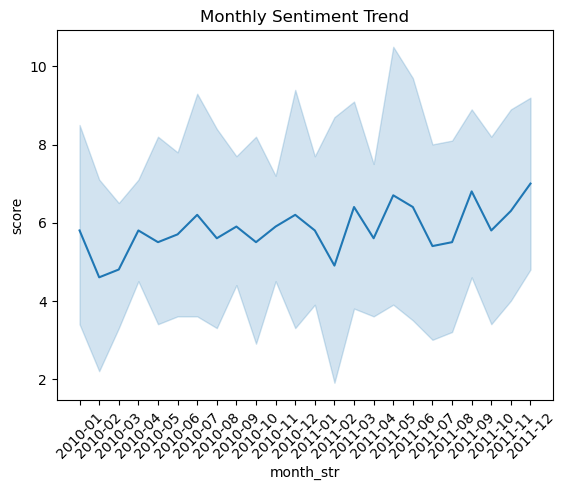

In [17]:
monthly_scores['month_str'] = monthly_scores['month'].astype(str)

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    data=monthly_scores,
    x='month_str',
    y='score'
)
plt.title("Monthly Sentiment Trend")
plt.xticks(rotation=45)
plt.show()

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X = features[['msg_count', 'avg_length']]
y = monthly_scores['score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 Score: 0.663586410214132
RMSE: 1.9632001931180072
